In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import glob as glob
import os
import math
import numpy as np

DIRECTORY = r"D:\images\images"

img_filepaths = [os.path.join(DIRECTORY, filename) for filename in os.listdir(DIRECTORY)]

In [2]:
def plt_images(img_filepaths, titles=[]):
    for idx, image_path in enumerate(img_filepaths):
        image = plt.imread(image_path)
        amount_of_cols = 10
        amount_of_rows = math.ceil(len(img_filepaths) / amount_of_cols) 
        plt.subplot(amount_of_rows, amount_of_cols,idx+1)
        plt.imshow(image)
        
        if titles:
            plt.title(titles[idx], fontsize=16)
        plt.axis('off')

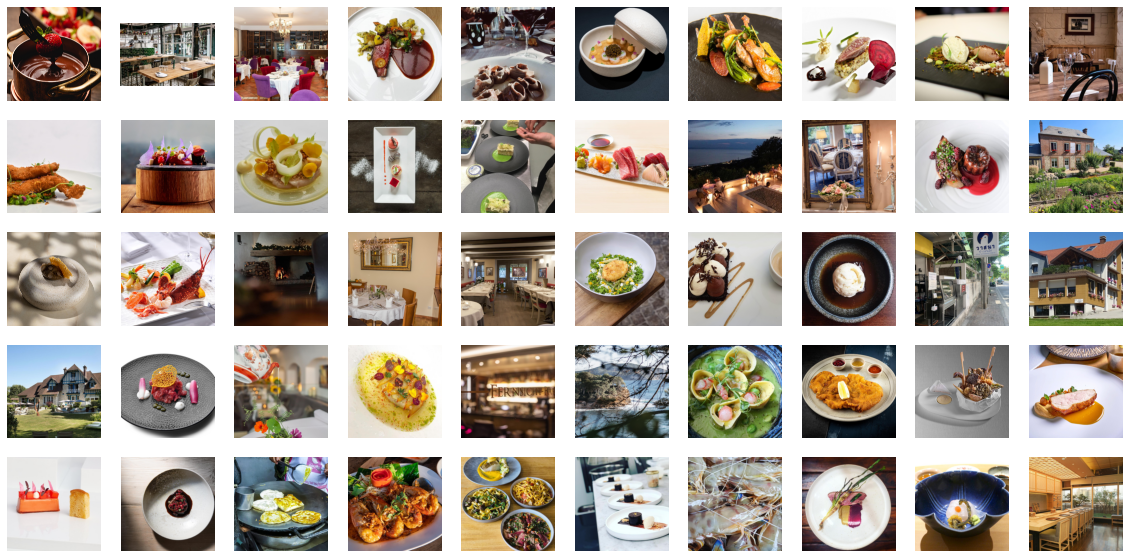

In [3]:
np.random.seed(0)

sample_size = 50
sample_filepaths = np.random.choice(img_filepaths, size=sample_size, replace=False)

plt.figure(figsize=(20,10))
plt_images(sample_filepaths)

## Upload pretrained image classification model

Ref: https://learnopencv.com/image-classification-pretrained-imagenet-models-tensorflow-keras/

The choice of which pre-trained model to use as a transfer basis for a 2-class classification task on a huge dataset depends on various factors such as the size of the dataset, the complexity of the problem, the availability of computing resources, and the specific requirements of the application.

In general, all three models, ResNet50, VGG16, and InceptionV3, can be used as a transfer basis for 2-class classification tasks. However, ResNet50 has been shown to outperform VGG16 and InceptionV3 on various computer vision tasks due to its residual connections and ability to train very deep neural networks.

If the dataset is very large, then ResNet50 may be more suitable as it has been shown to work well on large-scale datasets. However, if the dataset is not very large and the classification problem is not very complex, then VGG16 or InceptionV3 may also be suitable choices.

In practice, it is recommended to try out different pre-trained models and fine-tune them on the specific task and dataset to see which performs the best. It is also important to consider the trade-off between the accuracy of the model and the computational resources required to train and run the model.

In [4]:
#model_vgg16        = tf.keras.applications.vgg16.VGG16()
model_resnet50     = tf.keras.applications.resnet50.ResNet50()
# model_inception_v3 = tf.keras.applications.inception_v3.InceptionV3()

In [5]:
# the unspecified element is number of images in a batch
print(model_resnet50.input_shape)

(None, 224, 224, 3)


### Create a Convenience Function for Batch Processing

1. Read the images
2. Perform the required pre-processing for the images as required by the model
3. Add a batch dimension to the image tensor
4. Call the model’s predict() method to make predictions
5. Decode the predictions to find the class name and confidence score for the top-k predictions
6. Display the results

In [6]:
def process_images(model, image_paths, size, preprocess_input, display_top_k=False, top_k=3):
    result = []
    for idx, image_path in enumerate(image_paths):
     
        # Read the image using TensorFlow.
        tf_image = tf.io.read_file(image_path)
 
        # Decode the above `tf_image` from a Bytes string to a numeric Tensor.
        decoded_image = tf.image.decode_image(tf_image)
 
        # Resize the image to the spatial size required by the model.
        image_resized = tf.image.resize(decoded_image, size)
 
        # Add a batch dimension to the first axis (required). 
        image_batch = tf.expand_dims(image_resized, axis=0)
 
        # Pre-process the input image.
        image_batch = preprocess_input(image_batch)
 
        # Forward pass through the model to make predictions.
        preds = model.predict(image_batch)
 
        # Decode (and rank the top-k) predictions. 
        # Returns a list of tuples: (class ID, class description, probability)
        decoded_preds = tf.keras.applications.imagenet_utils.decode_predictions(
            preds=preds,
            top=5
        )
        
        result.append(decoded_preds[0][0][1])
        
    return result

### Make predictions on sample

In [7]:
%%time

model = model_resnet50
size = (224, 224) 
  
preprocess_input = tf.keras.applications.resnet50.preprocess_input
 
sample_labels = process_images(model, sample_filepaths, size, preprocess_input, display_top_k=True)

1/1 [==============================] - 0s 286ms/step
CPU times: total: 53.2 s
Wall time: 20.1 s


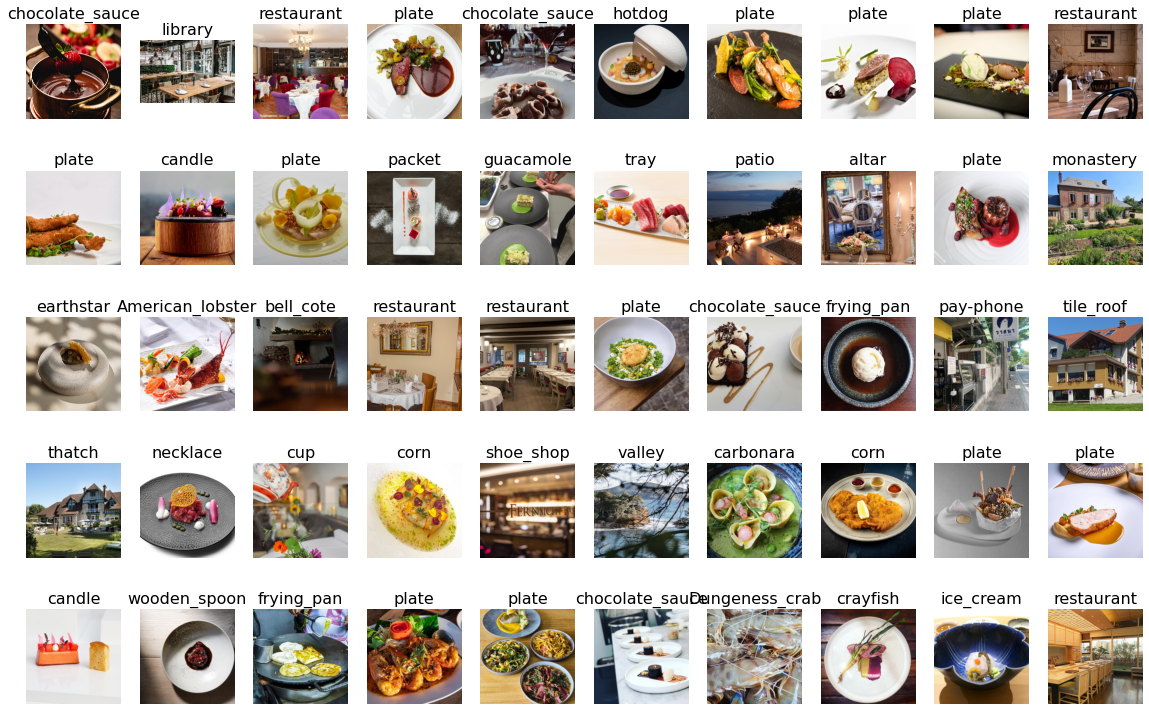

In [8]:
plt.figure(figsize=(20,13))

plt_images(sample_filepaths, sample_labels)

## Use word2vec to classify an image label as interior or as food or as interior

### Upload pretrained word2vec

https://kavita-ganesan.com/easily-access-pre-trained-word-embeddings-with-gensim/#.ZD7KJnbP2M9

We label an image in a follwoing way:
1. Is predicted image label closer (in word2vec sense) to 'building' than to 'eating'?
2. Image is **interior** if is close to 'building' else image is **food** 

In [9]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

w2v_model = api.load("glove-twitter-25")

In [10]:
INTERIOR = 'building'
FOOD = 'eating'

def is_interior(word): 
    try:
        if '_' in word: # adjective_noun case
            word = word.split('_')[1]
        return w2v_model.similarity(word, INTERIOR) > w2v_model.similarity(word, FOOD)
    except KeyError:
        return 1 # if a key is unusual -> it's probably a weird name for a dish
    

sample_is_interior = [is_interior(l) for l in sample_labels]

In [11]:
sample_titles = [f'{sample_labels[i]}/{INTERIOR if sample_is_interior[i] else FOOD}' for i in range(len(sample_is_interior))]

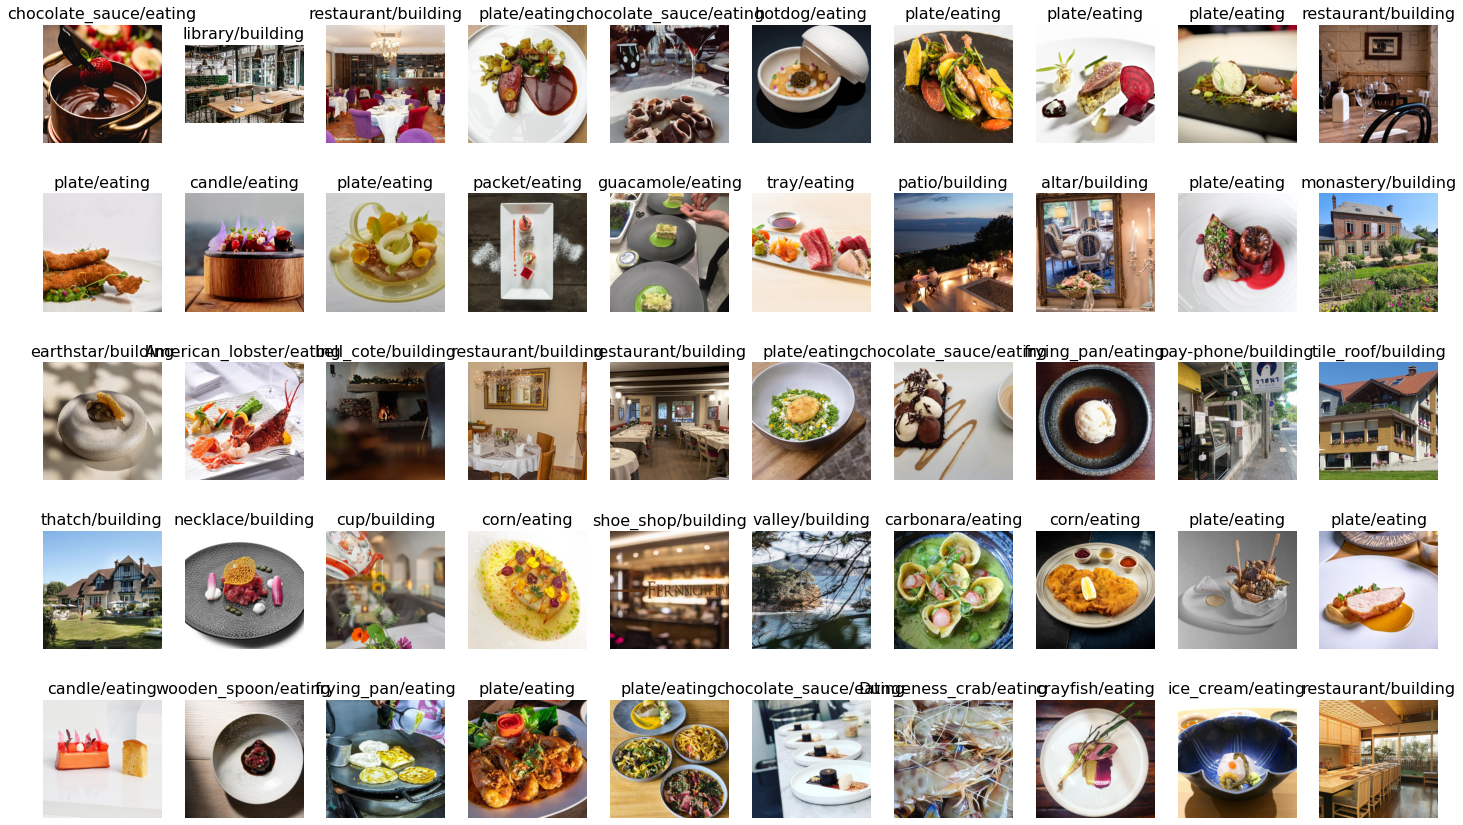

In [12]:
plt.figure(figsize=(25,15))

plt_images(sample_filepaths, sample_titles)